In [1]:
import math
import nltk
import string
import operator
from evaluate import evaluate

# Who will win 2016 election? 
##        Using Naive Bayes Model for Sentiment Analysis to Analyze Tweets about 2016 Election
Generally speaking, sentiment analysis aims to determine the attitude of a speaker or a writer with respect to some topic or the overall contextual polarity of a document. 

In this tutorial, we are going to implement a simple Naive Bayes Sentiment Classifier to classify text as being positive or negative. Then we are going to use the classifier we built to do simple analysis on tweets of 2016 election. Hope this will help you gain some insights into the public views of the presidential candidates. (Note this tutorial is just for educational purpose, no political views involved.)

The tutorial is divided into several parts. Firstly, you will process sentiment labelled data into bag-of-word representation. Secondly, you will learn to build a Naive Bayes Classifier based on the statistical property of text. We will also cover the evaluation of binary classifier. Finally, we will scrape tweets about 2016 election using Twitter search API, apply the classifier, and calculate sentiment score distribution and top words mentioned.

## Q0: Enviroment Setup

Before the tutorial starts, it is important to make sure you have all the dataset and python modules that needed.

Please download the dataset from [here](https://www.dropbox.com/sh/0g3wl2gdmvqmoi4/AABU1i71efGkg5LR_-lQo58sa?dl=0). 
    
It contains of 100M+ data and python modules we need for this tutorial. The downloaded folder also contains the same Jupyter Notebook for this tutorial. You can also run it to see the result. Note this tutorial cannot be executed without this downloaded folder since it contains python modules and datasets. Please make sure you download the file before trying to run it locally.


## Q1: Data Processing

In the first part of this tutorial: we will do data processing on sentiment labelled data. The dataset we use for training and validation comes from multiple datasets across the web: [Sentiment Labelled Sentences Data Set for Yelp, Amazon, imdb](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences), [University of Michigan Sentiment Analysis competition on Kaggle](https://inclass.kaggle.com/c/si650winter11), [Twitter Sentiment Analysis Training Corpus Dataset](http://thinknook.com/wp-content/uploads/2012/09/Sentiment-Analysis-Dataset.zip) and manully labelled data. The total number of labelled text is 1,580,857. The total number of text used for validation is 5,000.

The dataset format is:

    text + \t + score (0 for negative, 1 for positive)
We define following function data_process(training_data_file) to tokenize the raw data into bag-of-word representation.

In [2]:
def process_line(line):
    ''' process each line: 
        rules: lower all character, change "'s" to "s", eliminate all other punctuation characters
    Input: line
    Output: transformed line
    '''
    line = line.rstrip().lower().replace("'s", "").replace("'", "")
    for char in string.punctuation:
        line = line.replace(char, " ")    
    return line

def data_process(training_data_file):
    """ process all labelled data
    Inputs
        training_data_file: a file contains all labelled data file name
    Outputs
        vocabulary: dictionary, key is token, value is the frequency it appears in the training data
        sentiment_data: dictionay, key is the processed text, value is the label (0 for negative, 1 for positive)
        total: total number of valid processed data
        positive: total number of positive labelled data
        negative: total number of negative labelled data
    """
    
    training_data = open(training_data_file)
    stopwords = set(nltk.corpus.stopwords.words('english'))
    
    vocabulary = {}
    sentiment_data = {}
    total = 0
    positive = 0
    negative = 0
    
    # process each training data file
    for file in training_data:
        labelled_data_file = open(file.rstrip())
        labelled_data = ''
        for line in labelled_data_file:
            line = process_line(line)
            labelled_data += (line + " ")
    
            if "\t" in labelled_data:
                try:
                    # get text and its label
                    text = labelled_data.split("\t")[0]
                    label = int(labelled_data.split('\t')[1])
                    sentiment_data[text] = label
                    
                    # update labelled data count
                    total += 1
                    positive += label
                    
                    # tokenize and update term frequency
                    for token in text.split(" "):
                        if len(token) == 0 or token in stopwords:
                            continue
                        if token in vocabulary:
                            vocabulary[token] += 1
                        else:
                            vocabulary[token] = 1
                    labelled_data = ''
                except ValueError:
                    labelled_data = ''
                    continue 
        labelled_data_file.close()
    training_data.close()
    negative = total - positive
    return (vocabulary, sentiment_data, total, positive, negative)

In [3]:
vocabulary, sentiment_data, total, positive, negative = data_process("data/training_data.txt")
print "unique tokens: " + str(len(vocabulary))
print "positive data: " + str(positive) + ", negative data:  " + str(negative)

unique tokens: 670483
positive data: 795693, negative data:  793061


After running this call, We can tell that we have 670483 unique tokans and 1580857 labelled data. Next we are going to build a Naive Bayes classifier based on these processed text. 

    unique tokens: 670483
    positive data: 795693, negative data:  793061

## Q2: Build a Naive Bayes Sentiment Classifier

In the main portion of this tutorial, you will learn to build a Naive Bayes Sentiment Classifier. Naive Bayes Claasifier is known for creating simple yet well performing models, especially for text classification. It uses words in the text as features and assumes conditional independence across words. Therefore, the probabilty of the text under a certail class can be estimated by the words in the text.

Here are steps to build a Naive Bayes Classifier:

1. Estimate the prior probability $P(c)$ of each class c ∈ C. $P(c)$ can be obtained by dividing the number of data in class c by the total number of labelled data.
2. Estimate the probability distribution $P(w|c)$ for all words w and classes c. This can be done by dividing the total term frequency of w in class c by the total number of words in c.  However, estimating probability only according to observed data may lead to many zero probabilities, so recall from class, we introduce Laplace Smoothing when estimating $P(w|c) = \frac{tf + α}{C + αD}$, where C is the total number of words in class c, D is the total vocabulary count.
3. Use Bayes rule to estimate $P(c|d)$, the probablity of class c given a text d, we have:

   $P(c|d) = \frac{P(d|c)P(c)}{P(d)}$.
   
   Assume the words' positions don't matter and assume words are conditional independent (Naive Bayes rule), we have:
    
   $P(d|c) = P(w_1,w_2,w_3..w_N|c) = P(w_1|c)P(w_2|c)...P(w_N|c)$.
   
   

Finally, we can simply classify a text d to be its most likely class label, which is c with the highest probability $P(c|d)$,  using Naive Bayes rule, we can have following formula.

$\underset{c\in C}{\operatorname{argmax}}P(c|d) = \underset{c\in C}{\operatorname{argmax}}\frac{P(d|c)P(c)}{P(d)}
                   = \underset{c\in C}{\operatorname{argmax}} P(d|c)P(c)
                   = \underset{c\in C}{\operatorname{argmax}} P(w_1|c)P(w_2|c)...P(w_N|c)P(c)$.


In [4]:
class sentiment_classifier:
    """ Naive Bayes Sentiment Classifier
    Attributes:
        vocabulary: dictionary, key is token, value is the frequency it appears in the training data
        total: total number of valid processed data
        positive: total number of positive labelled data
        negative: total number of negative labelled data
        vocabulary_pos: dictionary, key is token, value is term frequency it appears in class positive
        vocabulary_neg: dictionary, key is token, value is term frequency it appears in class negative
        count_pos: total vocabulary in positive class
        count_neg: total vocabulary in negative class

    Inputs for _init_
        vocabulary: dictionary, key is token, value is the frequency it appears in the training data
        sentiment_data: dictionay, key is the processed text, value is the label (0 for negative, 1 for positive)
        total: total number of valid processed data
        positive: total number of positive labelled data
        negative: total number of negative labelled data
    """
    def __init__(self, vocabulary, sentiment_data, total, positive, negative):
        self.positive = positive
        self.negative = negative
        self.total = total
        self.vocabulary = vocabulary
        self.vocabulary_pos = {}
        self.vocabulary_neg = {}
        self.count_pos = 0
        self.count_neg = 0

        # get vocabulary and term frequency for each class
        for text in sentiment_data.keys():
            label = sentiment_data[text]
            if label is 1:
                for token in text.split(" "):
                    if len(token) == 0:
                        continue
                    self.count_pos += 1
                    if token in self.vocabulary_pos:
                        self.vocabulary_pos[token] += 1
                    else:
                        self.vocabulary_pos[token] = 1
            else:
                for token in text.split(" "):
                    if len(token) == 0:
                        continue
                    self.count_neg += 1
                    if token in self.vocabulary_neg:
                        self.vocabulary_neg[token] += 1
                    else:
                        self.vocabulary_neg[token] = 1

        # get probability p(w|c) for each word and class, using Laplace smooth
        q = 1
        total_vocabulary = len(vocabulary)
        for token in vocabulary.keys():
            tf_pos = 0.0
            if token in self.vocabulary_pos:
                tf_pos = self.vocabulary_pos[token]
            p_pos = float(tf_pos + q) / (self.count_pos + q * total_vocabulary)
            self.vocabulary_pos[token] = p_pos

            tf_neg = 0.0
            if token in self.vocabulary_neg:
                tf_neg = self.vocabulary_neg[token]
            p_neg = float(tf_neg + q) / (self.count_neg + q * total_vocabulary)
            self.vocabulary_neg[token] = p_neg

    def getScore(self, line, dict_pos, dict_neg):
        """ get sentiment score for a text line
        Inputs
            line: text
            dict_pos: dictionary used to store vocabulary occurred in positive class
            dict_neg: dictionary used to store vocabulary occurred in negative class
        Outputs
            score: sentiment score, defined as log(p(w|pos)) - log(p(d|neg))
                if score is positive, means it is a positive sentiment score
                if score is negative, means it is a negative sentiment score
        """
        line = process_line(line)
        p_pos = math.log(float(self.positive) / self.total)
        p_neg = math.log(float(self.negative) / self.total)
        tokens = line.split(" ")
        
        # multiply all probability for words in the text (using log fuction)
        for token in tokens:
            if token not in self.vocabulary:
                continue
            p_pos += math.log(self.vocabulary_pos[token])
            p_neg += math.log(self.vocabulary_neg[token])

        # output positive score for positive text
        if p_neg < p_pos:
            score = p_pos - p_neg
            for token in tokens:
                if token in set(nltk.corpus.stopwords.words('english')) or len(token) == 0:
                    continue
                if token in dict_pos:
                    dict_pos[token] += 1
                else:
                    dict_pos[token] = 1
        
        # output negative score for negative text
        else:
            score = p_pos - p_neg
            for token in tokens:
                if token in set(nltk.corpus.stopwords.words('english')) or len(token) == 0:
                    continue
                if token in dict_neg:
                    dict_neg[token] += 1
                else:
                    dict_neg[token] = 1
        return score


In [5]:
classifier = sentiment_classifier(vocabulary, sentiment_data, total, positive, negative)

## Q3: Evaluate Setiment Classifier

After building the classifier, it is important to evaluate the performance of our sentiment classifier. To evaluate a binary classfier, we can compute true_positive(TP), false_positive(FP), true_negative(TN) and false negative(FN). These can be arranged into a 2×2 contingency table to clear show the performance of the classifier.

We have assigned 5,000 labelled text as our validation data and define following function evaluate to calculate true_positive, false_positive, true_negative, false_negative. Due to the code limit, I have included the evaluate function in the evaluate.py attached to this tutorial.

In [6]:
'''
Evalute functoin specs:
    Args:
        classifier: trained naive bayes classifier
    Returns:
            (true_positive, false_positive, true_negative, false_negative) metrics used for evaluation
'''
true_positive, false_positive, true_negative, false_negative = evaluate(classifier)

In [7]:
print true_positive, false_positive, true_negative, false_negative 
print "accuracy: " + str((true_negative + true_positive) / float(true_negative+true_positive+false_positive+false_negative))

1134.0 310.0 2827.0 729.0
accuracy: 0.7922


Accuracy Evaluation for classifier is shown in the following table:

| | **positive**             |  **negative** |
|----------|-------------|
| **true_label**      | 1134 |2827|
|**false_label**|310|729|

In addition, precision and recall are the two most widely used metrics when evaluating text classifier. Here I will introduce the concept of precision and recall.

    Precision: the number of true positives divided by the total number of elements labeled as belonging to the positive class. P = TP / (TP + FP)

    Recall: the number of true positives divided by the total number of elements that actually belong to the positive class. R = TP / (TP + FN)
    
Precision and Recall for classifier:

| ** Precision **             |  **  Recall  ** |
|----------|-------------|
|0.7853|0.6087|

We find that the precision is higher which means most items labeled as positive do indeed belong to positive. However, recall is low which means that we will not be able to correctly label all the positive data. This might hurt the overall performance of the classifier as we will see a large proportion of false_negative. In fact, there is an inverse relationship between precision and recall, where it is possible to increase one at the cost of reducing the other. So when designing a classfier, one must take the trade-off between precision and recall into consideration.

## Q4: Scrape Tweets using Twitter Search API



Next, we are going to scrape some tweets about both Donald Trump and Hillary Clinton on Twitter for sentiment analysis. We will use search API in Twython library to search for tweets associated with a given hashtag. Please make sure you have installed Twython in your computer when trying to run the code. If you have not installed it, simply type following command on your terminal:

    pip install Twython

To make sure the code can run successfully, I have included the installation in the following cell. If needed, please comment out the cell and execuate the installation.

In [8]:
'''
This code is used to install Twython on your computer. You can also manually install using 'pip install Twython' 
If this went wrong, you can comment out this code.
'''
import pip
def install(package):
   pip.main(['install', package])

install('twython') 

The directory '/Users/yuqil/Library/Caches/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/Users/yuqil/Library/Caches/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.


Note that Twitter has a rate limit of 180 calls per second. So I have to call this function multiple times on different date to get enough data, which takes a long time to run. After calling this function, I also manually remove the duplicate tweets from the file. The unique tweets are stored at trump_unique_tweets.txt and hillary_unique_tweets.txt seperately for evaluation.

The following function getTwitter shows you how to scrape tweets about a specific hashtag. However, it is only for demonstration. The total scrape program takes 1h + to run due to rate limit.

In [9]:
from twython import Twython
import time
def getTwitter(twitter, hashtag, another_candidate, file):
    ''' Search for hashtag on Twitter, write tweets into file
    Input:
        twitter: Twitter API object
        hashtag: tag that need to be searched
        file: write tweets to a file
        another_candidate: we want to download tag with only one candidate, if another candidate appears in the tweet, we discard the tweet
    Output:
        total: total count of tweets wrote to the file
    '''
    tweets = set()
    MAX_ATTEMPTS = 10
    f = open(file, 'w')
    total = 0
    for i in range(0,MAX_ATTEMPTS):
        if(0 == i):
            results = twitter.search(q=hashtag,count='100',lang='en')
        else:
            results = twitter.search(q=hashtag,include_entities='true',max_id=next_max_id)

        for result in results['statuses']:
            tweet = process_line(result['text'])
            # we will drop tweets that contain both Hillary and Trump
            if tweet not in tweets and another_candidate not in tweet:
                tweets.add(tweet)
                f.write(tweet.encode("utf-8"))
                total += 1
        try:
            next_results_url_params = results['search_metadata']['next_results']
            next_max_id = next_results_url_params.split('max_id=')[1].split('&')[0]
        except:
            break
        time.sleep(0.5)
    f.close()
    return total

In [10]:
# this secret key is only for testing purpose, please do not distribute 
TWITTER_APP_KEY = 'Iivojv9n2hkVb2VsVShuxy2mp' 
TWITTER_APP_KEY_SECRET = 'trztK4S1e7nCRmLbGTLVdLiwo39J4vH8KaDu3NzmCliXKTC2KJ'
TWITTER_ACCESS_TOKEN = '783094143757221888-Z1IDng8gpD0LZyzR1aCjD5xRSGz68un'
TWITTER_ACCESS_TOKEN_SECRET = 'Wyfky6VJqUI6WcH2l5NI3dtk9KuZeOVL3u1YJL5P9LVS2'
twitter = Twython(app_key=TWITTER_APP_KEY, app_secret=TWITTER_APP_KEY_SECRET, oauth_token=TWITTER_ACCESS_TOKEN,
                  oauth_token_secret=TWITTER_ACCESS_TOKEN_SECRET)

print "number for hillary tweets: " + str(getTwitter(twitter, "#donaldtrump", "hilary", "trump_tweets.txt"))
print "number for trump tweets: " + str(getTwitter(twitter, "#hillaryclinton", "trump", "hillary_tweets.txt"))

number for hillary tweets: 56
number for trump tweets: 49


## Q5: Sentiment Analysis on Election Tweets


Finally, here comes the most fun part. We will apply the Naive Bayes Sentiment Classifier to the real tweets and see how public reviews towards two presidential candidates. While trying to get the sentiment score for the tweets, I also record what are the top words appear in positive and negative tweets. In total, I gathered 256 unique Tweets for Donald Trump and 379 unique Tweets for Hillary Clinton. 

In [11]:
import matplotlib
import matplotlib.pyplot as plt

def evaluateElection(classifier, filename):
    """ process all election data and output sentiment score
    Inputs
        classifier: sentiment classifier
        filenamae: file containing tweets
    Outputs
        none. Will print distribution of score for the topic
    """
    f = open(filename)
    dic_neg = {}
    dic_pos = {}
    result = []
    for line in f:
        score = classifier.getScore(line, dic_neg, dic_pos)
        result.append(score)
    f.close()
    sort_top_negative_word = sorted(dic_neg.items(), key=operator.itemgetter(1), reverse=True)[0 : 20]
    n, bins, patches = plt.hist(result, 50, normed=1, facecolor='green', alpha=0.75)
    plt.title("score distribution for " + filename)
    plt.show()
    print "Top negative words mentioned in " + filename + ":"
    print sort_top_negative_word

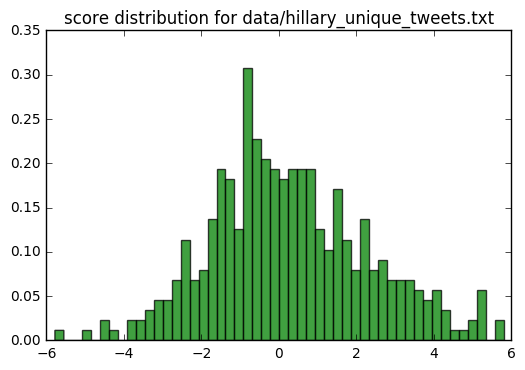

Top negative words mentioned in data/hillary_unique_tweets.txt:
[('hillary', 135), ('https', 125), ('co', 119), ('rt', 116), ('hillaryclinton', 73), ('clinton', 25), ('imwithher', 19), ('wikileaks', 19), ('emails', 19), ('podesta', 18), ('amp', 16), ('via', 15), ('part', 13), ('release', 13), ('vote', 12), ('podestaemails', 12), ('new', 11), ('obama', 10), ('8', 9), ('c0nvey', 8)]


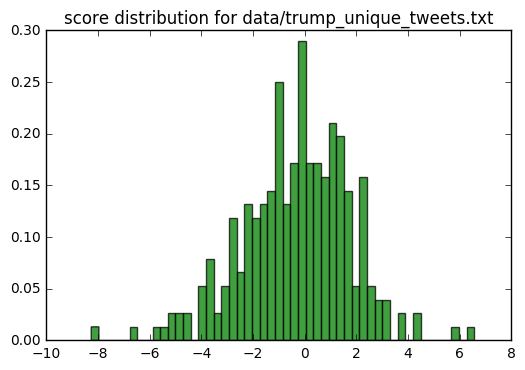

Top negative words mentioned in data/trump_unique_tweets.txt:
[('donaldtrump', 106), ('https', 82), ('co', 75), ('rt', 57), ('trump', 31), ('sexual', 13), ('groping', 12), ('women', 11), ('president', 9), ('amjoyshow', 9), ('genitalia', 7), ('gop', 7), ('monster', 7), ('assault', 7), ('bring', 7), ('amp', 7), ('misogynistic', 7), ('pussy', 7), ('today', 6), ('republican', 6)]


In [12]:
evaluateElection(classifier, 'data/hillary_unique_tweets.txt')
evaluateElection(classifier, 'data/trump_unique_tweets.txt')

Next, we plot the sentiment scores for tweets. The histogram plot shows the distribution of the score of all tweets. We can see that the distribution is similar to normal distribution where most people are neural to the candidates while there exist some strong supporters and strong opponents. 

The top words in the negative tweets show people's complain for each president candidate. For Donald Trump, the top words (except for some token in http..) include "sexual". For Hilary Clinton, the top words (except for some tokens in http..) include "wikileaks". This shows that sentiment analysis is also an effective way to mine the hot words about a topic.

However, the result is not always reliable. By manully inspecting the result, I found the classifier wrongly labelled many negative examples as positive. The reason might be due to the training data has little to do with politics. Most of the training data comes from product reviews and tweets about daily life. Only manually labelled data is about politics. 

## Final Take-Away Notes for this Tutorial

### 1. Training dataset is very important.
   I actually start with only one dataset of around 1,000 labelled data. The accuracy is only 0.6 on validation data. When I added more training dataset into the system, both accuracy and robustness of the classifier is greatly improved. Also the alignment with training data and validation data helps with the accuracy. For example, if you are going to build a sentiment classfier for Twitter, the Twitter dataset helps most while Yelp data might not be that helpful.
   
### 2. The power of Naive Bayes Model
   Naive Bayes model assumes conditional independence across different words. This assumption seems to be too simplified and not reasonable at first glance. Well, experiments show that this simple methods work pretty well especially for text classification. 
   
   Using only labelled data and its words' probabilty, we can actually build a Naive Bayes Model without much computational cost. Easy to use and well performed! So next time, if you are building a text classification, do not forget about Naive Bayes Model.
   
### 3. Other sentiment classification methods 
Besides Naive Bayes Model, there are also other popular sentiment classification methods. Many people use SVM for sentiment classification. It performs better than Naive Bayes but the computation cost is definitely higher. 

### Hope you enjoy the tutorial and welcome any suggestions and further discussion. Thanks!